## Gleason grading


In [1]:
%cd ..
# pass environment variables to jupyter notebook.
# %env DATA=/home/mahdigilany/projects_data/Exact

/home/mahdigilany/offline_codes/codes/TRUSnet


### datamodule

In [2]:

# from hydra.utils import instantiate
# from omegaconf import OmegaConf
# from src.lightning.datamodules.exact_datamodule import ExactPatchDMConfig

# dm_config = OmegaConf.structured(ExactPatchDMConfig(_target_="src.lightning.datamodules.exact_datamodule.PatchesConcatenatedFromCoresDataModule"))
# dm = instantiate(dm_config)
# val_ds = dm.val_ds

In [3]:
import pytorch_lightning as pl
pl.seed_everything(0)

/home/mahdigilany/anaconda3/envs/exact_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 0


0

In [4]:
from src.lightning.datamodules.exact_datamodule import ExactPatchDMConfig
from src.configuration import register_configs
from hydra import compose, initialize
from hydra.utils import instantiate 
from hydra.core.global_hydra import GlobalHydra
from omegaconf import OmegaConf
from rich import print as pprint

# dm_config = OmegaConf.structured(ExactPatchDMConfig(_target_="src.lightning.datamodules.exact_datamodule.PatchDataModuleForSupervisedLearning"))

register_configs()

GlobalHydra.instance().clear()
initialize(config_path="../configs", version_base="1.1")

dm_config = compose(
    config_name="datamodule/concatenated_cores.yaml", 
    overrides=["datamodule.splits.cohort_specifier=['UVA', 'CRCEO', 'PMCC', 'PCC']",
               "datamodule.splits.train_val_split_seed=1",
               "datamodule.splits.train_val_ratio=0.2",
               "datamodule.splits.test_as_val=True"]
    )
dm = instantiate(dm_config)
# pprint(OmegaConf.to_yaml(dm_config))

dm = dm['datamodule']
print(dm.root)
dm.setup()


/home/mahdigilany/projects_data/Exact


Loading Patch Views: 100%|██████████| 77/77 [00:00<00:00, 11911.68it/s]


In [5]:
train_dl_list = [dm.train_dataloader()]
val_dl_list = dm.val_dataloader()
test_dl_list = dm.test_dataloader()
len(val_dl_list)
# test_ds_dict = dm.test_ds

8

In [6]:
val_dl_UVA = val_dl_list[0]
test_dl_UVA = test_dl_list[0]

In [7]:
# batch = next(iter(val_dl_UVA))
# batch[2]

### model

In [8]:
from src.modeling.registry import create_model

model = create_model(model_name="grade_linear_all_centers", with_sampler=False)


/home/mahdigilany/anaconda3/envs/exact_env/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
  rank_zero_warn(


In [9]:
from pytorch_lightning.utilities.model_summary import ModelSummary

ModelSummary(model, max_depth=1)

  | Name         | Type               | Params
----------------------------------------------------
0 | train_acc    | Accuracy           | 0     
1 | backbone     | VICReg             | 5.7 M 
2 | head_network | MultiheadAttention | 1.1 M 
----------------------------------------------------
6.8 M     Trainable params
0         Non-trainable params
6.8 M     Total params
27.352    Total estimated model params size (MB)

### trainer/tester

In [10]:
# import pytorch_lightning as pl

# trainer = pl.Trainer(gpus=1, max_epochs=1)
# validation_epoch_end_outputs = trainer.test(model, dataloaders=test_dl_UVA)

In [11]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# accumulating logits and labels in logits_list and labels_list
logits_list = []
labels_list = []

# accumulating metadata dictionaries in a pandas dataframe 
import pandas as pd
metadata_list = []

for _loader in train_dl_list[:4]:
    for batch in _loader:
        x = batch[0].to(device)
        pos = batch[1]
        y = batch[2]
        metadata = batch[3:]
        
        loss, logits, labels, *metadata = model.shared_step(tuple([x, pos, y, *metadata]))
        
        metadata_list.append(metadata[0])
        logits_list.append(logits.detach().cpu())
        labels_list.append(labels.detach().cpu())
    
logits = torch.cat(logits_list) # (N, 3)
labels = torch.cat(labels_list) # (N,)
metadata_df = pd.DataFrame(metadata_list)

### getting performance

In [12]:
# logits.softmax(dim=1).argmax(dim=1)
# finding macro accuracy and auroc using labels and logits.
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, accuracy_score
acc = accuracy_score(labels, logits.softmax(dim=1).argmax(dim=1))
b_acc = balanced_accuracy_score(labels, logits.softmax(dim=1).argmax(dim=1))
auc = roc_auc_score(labels, logits.softmax(dim=1), multi_class="ovr",average=None)

print(f"acc: {acc}, b_acc: {b_acc}, auc: {auc}")

# getting the same metrics using pytorch lightning
from torchmetrics.functional.classification import accuracy, auroc
acc = accuracy(logits, labels, num_classes=3, average="none", multiclass=True)
auc = auroc(logits, labels, num_classes=3, average="None")

print(f"b_acc: {acc}, auc: {auc}")

acc: 0.639618138424821, b_acc: 0.5141060643666749, auc: [0.78218843 0.74096101 0.74488491]
b_acc: tensor([0.7500, 0.6551, 0.1373]), auc: tensor([0.7816, 0.7290, 0.7407])


### checking predictions 

In [13]:
import numpy as np
print(labels)
print(logits.softmax(dim=1).argmax(dim=1))
print(torch.sum(labels == 0))

tensor([0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 2, 0, 0, 1, 2, 0, 0, 1, 0, 1, 0, 0, 1, 1,
        1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 2, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 2, 0, 0,
        0, 1, 0, 1, 0, 2, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 2, 1, 0,
        2, 0, 1, 0, 1, 1, 2, 0, 0, 0, 2, 1, 1, 1, 0, 1, 0, 2, 1, 1, 0, 2, 0, 0,
        1, 1, 0, 1, 0, 0, 0, 2, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 1, 0, 1,
        0, 0, 1, 1, 0, 0, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 2, 1, 1, 1, 1, 0, 0, 0,
        2, 0, 0, 0, 1, 0, 2, 0, 0, 2, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 0, 2, 0, 2,
        0, 2, 2, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 2, 0, 1, 0, 1, 0,
        1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 2, 0, 0, 1, 0, 0, 2, 0, 1, 0,
        1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 2, 0, 0, 2, 0, 1, 0, 0,
        1, 0, 0, 1, 0, 1, 2, 0, 2, 1, 0,

### testing loading from checkpoint

In [14]:
from src.utils.checkpoints import get_named_checkpoint
from src.lightning.lightning_modules.self_supervised.finetune import CoreGradeFinetuner
from omegaconf import OmegaConf
from dataclasses import dataclass

# ckpt_name = f"grading_Multattn-sl_all-centrs_ssl-pretrain_all-centrs"
# ckpt_path = get_named_checkpoint(ckpt_name)

# ckpt_path = "./logs/experiments/runs/Grading_Multattn-sl_all-centrs_ssl-pretrain_all-centrs_bsz20/" \
#     "2022-11-29_18-15-46/checkpoints/epoch_017.ckpt"

ckpt_path = "/home/mahdigilany/projects_data/Exact/checkpoint_store/epoch_011.ckpt"


@dataclass
class Backbone:
    _target_: str = "src.modeling.registry.create_model"
    model_name: str = "vicreg_resnet10_pretrn_allcntrs_noPrst_ndl_crop"
    split_seed: int = 1

backbone_conf = OmegaConf.structured(Backbone)
model = CoreGradeFinetuner.load_from_checkpoint(ckpt_path, backbone=backbone_conf)

model_notloaded = create_model(model_name="vicreg_resnet10_pretrn_allcntrs_noPrst_ndl_crop", split_seed=1)
# print(torch.load(ckpt_path)['state_dict']['backbone.backbone.layer1.0.conv1.weight'])
# print(model_notloaded.backbone.layer1[0].conv1.weight)
# print(model.backbone.backbone.layer1[0].conv1.weight)


# instantiating head network using structured config
from omegaconf import OmegaConf
from src.lightning.lightning_modules.self_supervised.finetune import HeadNetConfig

head_config = OmegaConf.structured(HeadNetConfig)
head_network = instantiate(head_config)

print(model.head_network.linears[0].weight)
# print(head_network.linears[0].weight)

Parameter containing:
tensor([[ 1.6366e-02,  1.2715e-02,  9.7730e-03,  ..., -3.1610e-02,
          1.3288e-02,  2.8237e-06],
        [-2.7461e-02,  1.1492e-02,  3.6739e-02,  ..., -2.5170e-02,
         -2.7714e-02, -1.1655e-02],
        [-2.5266e-02,  3.5729e-02,  1.9143e-02,  ..., -1.0565e-02,
         -4.7182e-03,  3.0842e-02],
        ...,
        [-1.0982e-02,  2.7076e-02,  1.9341e-02,  ..., -2.3310e-02,
          1.5406e-03,  3.0218e-02],
        [-1.2433e-02, -1.0591e-02, -3.3257e-03,  ...,  9.9350e-03,
         -1.4610e-02, -3.1932e-03],
        [-2.2631e-02,  3.4880e-02, -1.2592e-02,  ...,  1.5350e-02,
          2.2455e-02, -2.0288e-02]], requires_grad=True)


/home/mahdigilany/anaconda3/envs/exact_env/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
  rank_zero_warn(


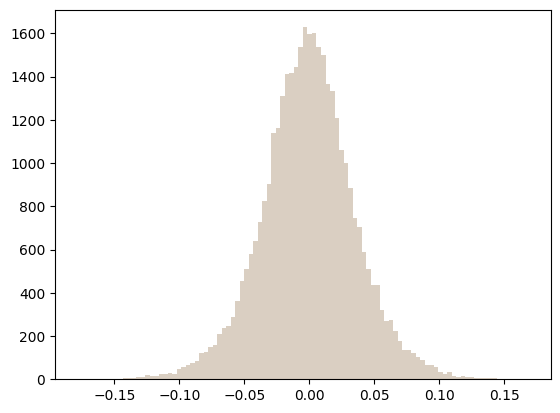

In [15]:
# plotting the histogram of the weights of the first convolutional layer of the backbone.
import matplotlib.pyplot as plt

plt.hist(model.backbone.backbone.layer1[0].conv1.weight.detach().cpu().flatten(), bins=100, alpha=0.2)
plt.hist(model_notloaded.backbone.layer1[0].conv1.weight.detach().cpu().flatten(), bins=100, alpha=0.2)
# plt.hist(torch.load(ckpt_path)['state_dict']['backbone.backbone.layer1.0.conv1.weight'].detach().cpu().flatten(),
        #  bins=100, alpha=0.2)
plt.show()


### another testing loading from checkpoint

In [16]:
from src.utils.checkpoints import get_named_checkpoint
from src.lightning.lightning_modules.self_supervised.finetune import CoreGradeFinetuner
from omegaconf import OmegaConf
from dataclasses import dataclass

# ckpt_name = f"grading_Multattn-sl_all-centrs_ssl-pretrain_all-centrs"
# ckpt_path = get_named_checkpoint(ckpt_name)

# ckpt_path = "./logs/experiments/runs/Grading_Multattn-sl_all-centrs_ssl-pretrain_all-centrs_bsz20/" \
#     "2022-11-29_18-15-46/checkpoints/epoch_017.ckpt"

ckpt_path = "/home/mahdigilany/projects_data/Exact/checkpoint_store/epoch_011.ckpt"
sd = torch.load(ckpt_path)


feat_extractor = create_model("vicreg_resnet10_pretrn_allcntrs_noPrst_ndl_crop", split_seed=1)
# print(feat_extractor.backbone.layer1[0].conv1.weight)
feat_sd = {
    k.removeprefix("backbone."): v
    for k, v in sd["state_dict"].items()
    if "backbone" in k
}
feat_extractor.load_state_dict(feat_sd)
# print(feat_extractor.backbone.layer1[0].conv1.weight)


head_net = create_model("attention_classifier", token_dim=512, num_classes=3)
# print(head_net.linears[0].weight)
head_sd = {
    k.removeprefix("head_network."): v
    for k, v in sd["state_dict"].items()
    if "head_network" in k
}
head_net.load_state_dict(head_sd)
# print(head_net.linears[0].weight)
# print(model.head_network.linears[0].weight)


<All keys matched successfully>

### Visualizing predictions

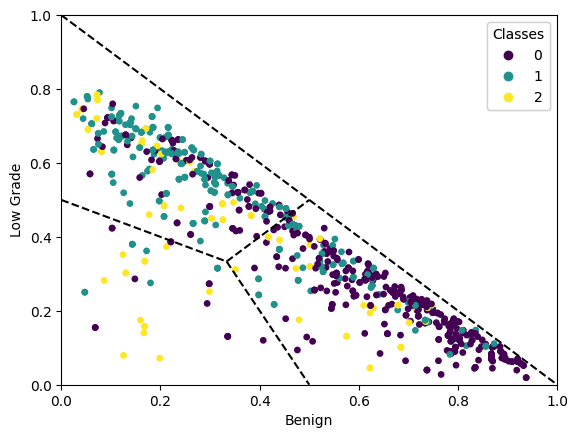

In [17]:
import matplotlib.pyplot as plt
_labels = labels.numpy()
_logits = logits.softmax(dim=1).numpy()

# plotting first and second dimension of logits with color coding based on the labels
fig, ax = plt.subplots()
# scatter = ax.scatter(_logits[:, 0], _logits[:, 1], c=_logits.argmax(axis=1), s=15,)
scatter = ax.scatter(_logits[:, 0], _logits[:, 1], c=_labels, s=15,)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)

# set the scale of x and y axis to be the same from 0 to 1
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
# produce labels for the plot. x axis should be called benign and y axis should be called Low Grade
ax.set_xlabel("Benign")
ax.set_ylabel("Low Grade")

x = np.linspace(1/3, .5, 100)
y = x
ax.plot(x, y, color="black", linestyle="--")


y = 1 - 2*x
ax.plot(x, y, color="black", linestyle="--")

x = np.linspace(0, 1/3, 100)
y = 0.5 - 0.5*x
ax.plot(x, y, color="black", linestyle="--")

x = np.linspace(0, 1, 100)
y = 1 - x
ax.plot(x, y, color="black", linestyle="--")

plt.show()
# print(labels.numpy())

### Testing part

In [30]:
# getting properties of train loader 
# train_dl_list[0].__dict__
train_dl_list[0].dataset.__dict__
# dir(train_dl_list[0].dataset)
# dir(train_dl_list[0])
# model.__class__
# model.__name__

{'patch_view_config': {'patch_size': [5, 5], 'patch_strides': [1, 1], 'subpatch_size': [1, 1], 'needle_region_only': True, 'prostate_region_only': False, 'prostate_intersection_threshold': 0.9, 'needle_intersection_threshold': 0.6},
 'patch_transform': <src.data.exact.transforms.TransformV3 at 0x7f4bbe840d90>,
 'target_transform': <function src.lightning.datamodules.exact_datamodule.DEFAULT_LABEL_TRANSFORM(label)>,
 'metadata_transform': <function src.lightning.datamodules.exact_datamodule.DEFAULT_METADATA_TRANSFORM(metadata)>,
 'root': '/home/mahdigilany/projects_data/Exact',
 'metadata':      patient_id                                     path_on_server center  \
 0             4  /med-i_data/Data/Exact_Ultrasound/data/full_da...  CRCEO   
 1             6  /med-i_data/Data/Exact_Ultrasound/data/full_da...  CRCEO   
 2            12  /med-i_data/Data/Exact_Ultrasound/data/full_da...  CRCEO   
 3            15  /med-i_data/Data/Exact_Ultrasound/data/full_da...  CRCEO   
 4            

In [53]:
# show meta data of the dataset and only show primary_grade 3
meta_data = train_dl_list[0].dataset.metadata
meta_data[(meta_data["primary_grade"] == 3) & (meta_data["secondary_grade"] == 4 )]
# type(meta_data["secondary_grade"] == 4)

# pandas series to numpy array
# (meta_data["secondary_grade"] == 4).to_numpy()

,patient_id,path_on_server,center,loc,grade,age,family_history,psa,pct_cancer,primary_grade,secondary_grade,patient_specifier,core_specifier
